## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from recommender import matrix_factorization

In [2]:
movies = pd.read_csv("data/links_small.csv")

In [3]:
movies.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


In [5]:
ratings = pd.read_csv("data/ratings_small.csv")

In [6]:
##Columns not needed
ratings.drop('timestamp', axis=1, inplace=True)

In [7]:
## Order by movieId
ratings.sort_values('movieId', inplace=True)

In [8]:
## Remove float ratings by casting to int
ratings['rating'] = ratings['rating'].astype(int)

In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100004 entries, 9713 to 80823
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   100004 non-null  int64
 1   movieId  100004 non-null  int64
 2   rating   100004 non-null  int32
dtypes: int32(1), int64(2)
memory usage: 2.7 MB


In [10]:
ratings.head()

,userId,movieId,rating
9713,68,1,4
35933,261,1,1
52631,383,1,5
35983,262,1,2
12038,77,1,4


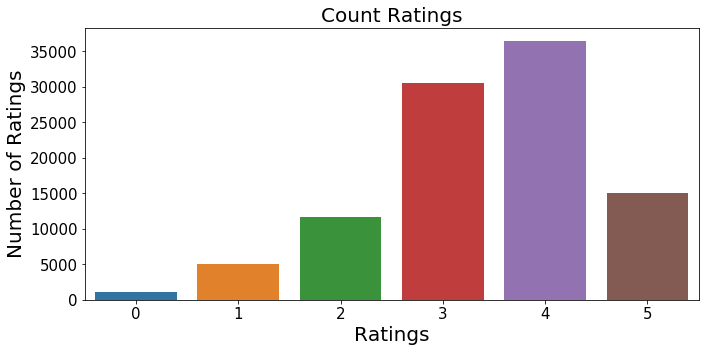

In [11]:
plt.figure(figsize = (11, 5))
sns.countplot(x="rating", data=ratings)
plt.tick_params(labelsize = 15)
plt.title("Count Ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [12]:
## Group by userid and count the numbers of movies rated by that user
ratings.groupby("userId")["rating"].count().sort_values(ascending = False).head()

userId
547    2391
564    1868
624    1735
15     1700
73     1610
Name: rating, dtype: int64

In [13]:
## Group by movies and count the number of users rated that movie
ratings.groupby("movieId")["rating"].count().sort_values(ascending = False).head()

movieId
356    341
296    324
318    311
593    304
260    291
Name: rating, dtype: int64

In [14]:
## set userId as index
ratings = ratings.set_index('userId').sort_index(axis = 0)

In [15]:
ratings

,movieId,rating
userId,,
1,2455,2
1,1287,2
1,2968,1
1,1339,3
1,1172,4
...,...,...
671,1266,4
671,1197,3
671,4022,3


In [16]:
## pivot df to get the matrix Yai
ratings = ratings.pivot(index=ratings.index, columns='movieId')['rating']

In [17]:
## replace NAN with zero
ratings = ratings.fillna(0)

In [18]:
ratings

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
## Transform pandas df to numnpy array
ratings_array = ratings.to_numpy()

In [20]:
## Create the Recommender System object
k=2
recomm = matrix_factorization(ratings_array,k)

In [ ]:
## Train the model
recomm.fit()

In [ ]:
## Get the Predicted matrix
recomm.matrix

In [ ]:
## Plot MSE over iterations
plt.figure(figsize=(11, 5))
plt.plot(recomm1.mse)
plt.show()

In [ ]:
mse = []
for k in range(1, 50, 1):
    r = matrix_factorization(a,k) ## need to use cross validation
    r.fit()
    mse.append(np.mean(r.mse))

In [ ]:
a = np.array([

     [5,3,0,1],

     [4,0,0,1],

     [1,1,0,5],

     [1,0,0,4],

     [0,1,5,4],
    
     [2,1,3,0],

    ])

In [ ]:
recomm1 = matrix_factorization(a,3)
recomm1.fit(iterations=1000)
recomm1.matrix

In [ ]:
plt.figure(figsize=(11, 5))
plt.plot(mse)
plt.xlim(0,len(mse))
plt.xlabel("k")
plt.ylabel("RMSE")
plt.axvline(np.argmin(mse), color = "r")
plt.show()